# 1. Project Overview & Notebook Setup

This notebook performs the initial exploratory data analysis (EDA) and data preparation for a dynamic pricing project using the Olist e-commerce dataset.

**Goals of this notebook (part 1):**
- Load all core Olist tables (orders, items, products, sellers, categories, etc.)
- Build a unified **`listings`** table that combines order, product, and seller information
- Prepare this master table for deeper EDA and later feature engineering

We start by importing libraries and configuring global settings for visualization and display.

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import gc
import warnings

# Visualization settings
plt.style.use("seaborn-v0_8")
sns.set()
warnings.filterwarnings("ignore")

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# 2. Load Raw Olist Data

In this section, we load all raw Olist tables from `../data/raw/` into memory using a helper function.

**Tables loaded:**
- `customers` – customer IDs and locations  
- `geolocation` – zipcode-to-location mapping  
- `orders` – order-level metadata (status, timestamps, customer)  
- `order_items` – item-level details per order (product, seller, price, freight)  
- `order_payments` – payment method and values  
- `order_reviews` – customer review scores and comments  
- `products` – product attributes and category labels  
- `sellers` – seller locations  
- `category_translation` – mapping of Portuguese category names to English

We also print the shape of each table to confirm successful ingestion.

In [167]:
import pandas as pd
import os

# Path relative to notebook location:
DATA_PATH = "../data/raw"

def load_olist_data():
    datasets = {
        "customers": "olist_customers_dataset.csv",
        "geolocation": "olist_geolocation_dataset.csv",
        "order_items": "olist_order_items_dataset.csv",
        "order_payments": "olist_order_payments_dataset.csv",
        "order_reviews": "olist_order_reviews_dataset.csv",
        "orders": "olist_orders_dataset.csv",
        "products": "olist_products_dataset.csv",
        "sellers": "olist_sellers_dataset.csv",
        "category_translation": "product_category_name_translation.csv",
    }
    
    loaded = {}
    for name, filename in datasets.items():
        path = os.path.join(DATA_PATH, filename)

        # All current files are CSV; TSV logic kept for flexibility
        if filename.endswith(".tsv"):
            df = pd.read_csv(path, sep="\t", encoding="latin1", low_memory=False)
        else:
            df = pd.read_csv(path, encoding="latin1", low_memory=False)

        loaded[name] = df
        print(f"Loaded: {name:<20} → {df.shape[0]:>7} rows, {df.shape[1]:>2} cols")

    return loaded

# Load everything
data = load_olist_data()

Loaded: customers            →   99441 rows,  5 cols
Loaded: geolocation          → 1000163 rows,  5 cols
Loaded: order_items          →  112650 rows,  7 cols
Loaded: order_payments       →  103886 rows,  5 cols
Loaded: order_reviews        →   99224 rows,  7 cols
Loaded: orders               →   99441 rows,  8 cols
Loaded: products             →   32951 rows,  9 cols
Loaded: sellers              →    3095 rows,  4 cols
Loaded: category_translation →      71 rows,  2 cols


# 3. Extract Core Tables & Quick Sanity Checks

Now we extract each table from the loaded dictionary into separate variables for easier exploration.

We’ll do a quick check on:
- `orders` – preview a few rows  
- `products` – inspect schema and missingness  
- `order_items` – sample a few rows to understand the item-level structure

In [168]:
# Extract tables for convenience
customers            = data["customers"]
geolocation          = data["geolocation"]
order_items          = data["order_items"]
order_payments       = data["order_payments"]
order_reviews        = data["order_reviews"]
orders               = data["orders"]
products             = data["products"]
sellers              = data["sellers"]
category_translation = data["category_translation"]

# Quick sanity checks
display(orders.head())
print("\nProducts info:")
products.info()

print("\nSample order_items:")
display(order_items.sample(5, random_state=42))

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00



Products info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB

Sample order_items:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
107777,f4ee4273538924bda6212f5948e80fde,1,69455f41626a745aea9ee9164cb9eafd,7d13fca15225358621be4086e1eb0964,2018-06-19 09:18:15,180.0000,20.4500
2391,056349f85a73d794119c4286c95a52de,1,af35be35db4ad0dc288b571453337376,d20b021d3efdf267a402c402a48ea64b,2017-03-09 14:35:09,10.9900,16.0500
77829,b124967afcc82ef17ec41020fe2a9136,1,12e6d0f655986ceff00c74658dec97b1,3be634553519fb6536a03e1358e9fdc7,2018-06-06 17:18:09,49.9900,8.8800
99819,e257ae8610fb4fb68a1f459c3a4b1f51,1,a50acd33ba7a8da8e9db65094fa990a4,8581055ce74af1daba164fdbd55a40de,2017-05-18 08:02:19,117.3000,14.4300
41297,5e114d8e3840661abc3d9c4820f427b3,1,5cca3efb9521cc1d7099d610d4a12017,3d871de0142ce09b7081e2b9d1733cb1,2018-05-03 18:15:09,58.9000,13.7700


# 4. Fix Category Translation Table (BOM + Column Names)

The `product_category_name_translation` file sometimes contains a weird BOM prefix in the column name.  
Here we fix the column names and verify that the Portuguese and English category labels are correctly aligned.

In [169]:
# Fix the weird BOM prefix in the first column, if present
category_translation = category_translation.rename(
    columns={"ï»¿product_category_name": "product_category_name"}
)

print("products columns:\n", products.columns.tolist())
print("\ncategory_translation columns:\n", category_translation.columns.tolist())

products columns:
 ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

category_translation columns:
 ['product_category_name', 'product_category_name_english']


# 5. Enrich Products with English Category Names

We now merge the `products` table with `category_translation` to attach an English category label to each product.

This will be useful for:
- Making plots more interpretable
- Communicating results to a non-Portuguese-speaking audience

In [170]:
# Merge products with category translation to get English category names
products_merged = products.merge(
    category_translation,
    how="left",
    on="product_category_name"
)

# Rename translated column for clarity
products_merged = products_merged.rename(
    columns={"product_category_name_english": "category_english"}
)

products_merged[["product_id", "product_category_name", "category_english"]].head()

,product_id,product_category_name,category_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,housewares


# 6. Build a Unified Item–Product Table

Next, we combine **order item–level data** with enriched product information.

This gives us, for each order item:
- Price and freight  
- Product attributes (dimensions, weight, photos)  
- Original and English category labels

In [171]:
# Merge order_items with the enriched products table
items_products = order_items.merge(
    products_merged,
    how="left",
    on="product_id"
)

items_products.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9000,13.2900,cool_stuff,58.0000,598.0000,4.0000,650.0000,28.0000,9.0000,14.0000,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9000,19.9300,pet_shop,56.0000,239.0000,2.0000,"30,000.0000",50.0000,30.0000,40.0000,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0000,17.8700,moveis_decoracao,59.0000,695.0000,2.0000,"3,050.0000",33.0000,13.0000,33.0000,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.9900,12.7900,perfumaria,42.0000,480.0000,1.0000,200.0000,16.0000,10.0000,15.0000,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9000,18.1400,ferramentas_jardim,59.0000,409.0000,1.0000,"3,750.0000",35.0000,40.0000,30.0000,garden_tools


# 7. Add Order-Level Information

We now merge in the `orders` table to bring in:
- Customer IDs  
- Order status  
- Purchase, approval, and delivery timestamps  
- Estimated delivery dates

This transforms our dataset into a rich **item × order** table.

In [172]:
items_products_orders = items_products.merge(
    orders,
    how="left",
    on="order_id"
)

items_products_orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9000,13.2900,cool_stuff,58.0000,598.0000,4.0000,650.0000,28.0000,9.0000,14.0000,cool_stuff,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9000,19.9300,pet_shop,56.0000,239.0000,2.0000,"30,000.0000",50.0000,30.0000,40.0000,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0000,17.8700,moveis_decoracao,59.0000,695.0000,2.0000,"3,050.0000",33.0000,13.0000,33.0000,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.9900,12.7900,perfumaria,42.0000,480.0000,1.0000,200.0000,16.0000,10.0000,15.0000,perfumery,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9000,18.1400,ferramentas_jardim,59.0000,409.0000,1.0000,"3,750.0000",35.0000,40.0000,30.0000,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00


# 8. Add Seller Information and Build the `listings` Table

Finally, we attach seller information (ZIP code, city, state) to each item-level row.

The result is our main **`listings`** table, which combines:
- Order item details  
- Product attributes & categories  
- Order-level metadata  
- Seller location

This unified table will be the foundation for pricing EDA and downstream modeling.

In [173]:
# Merge with sellers to add seller location
listings = items_products_orders.merge(
    sellers,
    how="left",
    on="seller_id"
)

# Inspect the first few rows of the unified listings table
listings.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9000,13.2900,cool_stuff,58.0000,598.0000,4.0000,650.0000,28.0000,9.0000,14.0000,cool_stuff,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,27277,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9000,19.9300,pet_shop,56.0000,239.0000,2.0000,"30,000.0000",50.0000,30.0000,40.0000,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,3471,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0000,17.8700,moveis_decoracao,59.0000,695.0000,2.0000,"3,050.0000",33.0000,13.0000,33.0000,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,37564,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.9900,12.7900,perfumaria,42.0000,480.0000,1.0000,200.0000,16.0000,10.0000,15.0000,perfumery,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,14403,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9000,18.1400,ferramentas_jardim,59.0000,409.0000,1.0000,"3,750.0000",35.0000,40.0000,30.0000,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,87900,loanda,PR


# 3. Data Cleaning

Now that we have a unified `listings` table, we need to clean and normalize it before deeper EDA and modeling.

**Objectives in this section:**
- Ensure correct data types (dates, numeric columns)
- Handle missing values in key fields
- Create a few basic derived features (e.g., product volume, shipping times)
- Remove extreme price outliers that may distort analysis

In [174]:
# lets make a working copy 
listings_clean = listings.copy()

# Convert date columns to datetime 
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    if col in listings_clean.columns:
        listings_clean[col] = pd.to_datetime(listings_clean[col], errors="coerce")

# Convert key numeric columns to numeric (in case any weird strings slipped in) 
numeric_cols = [
    "price",
    "freight_value",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm"
]

for col in numeric_cols:
    if col in listings_clean.columns:
        listings_clean[col] = pd.to_numeric(listings_clean[col], errors="coerce")
 
print("Data types after conversion:")
listings_clean.dtypes.head(15)

Data types after conversion:


order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date            object
price                         float64
freight_value                 float64
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

### 3.2 Handle Missing Values

Next, we handle missing values:

- Drop rows with missing **essential identifiers or price**
- Impute product dimensions with median values (they’re useful for volume-based features)

In [175]:
# Drop rows missing essential IDs or price
essential_cols = ["order_id", "product_id", "price"]
listings_clean = listings_clean.dropna(subset=essential_cols)

# Impute product dimensions with column medians
dim_cols = ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]

for col in dim_cols:
    if col in listings_clean.columns:
        median_val = listings_clean[col].median()
        listings_clean[col] = listings_clean[col].fillna(median_val)

print("Missing values handled for essential columns and product dimensions.")
listings_clean[dim_cols].isnull().sum()

Missing values handled for essential columns and product dimensions.


product_weight_g     0
product_length_cm    0
product_height_cm    0
product_width_cm     0
dtype: int64

### 3.3 Create Basic Derived Features

We add a few simple, but useful, engineered features:

- **product_volume_cm3** = length × width × height  
- **shipping_time_days** = delivered date − purchase date  
- **delivery_delay_days** = delivered date − estimated delivery date  

In [176]:
# Product volume (in cubic centimeters)
listings_clean["product_volume_cm3"] = (
    listings_clean["product_length_cm"] *
    listings_clean["product_width_cm"] *
    listings_clean["product_height_cm"]
)

# Shipping time: how many days between purchase and delivery to customer
listings_clean["shipping_time_days"] = (
    listings_clean["order_delivered_customer_date"] - listings_clean["order_purchase_timestamp"]
).dt.days

# Delivery delay: positive = late, negative = early
listings_clean["delivery_delay_days"] = (
    listings_clean["order_delivered_customer_date"] - listings_clean["order_estimated_delivery_date"]
).dt.days

listings_clean[["product_volume_cm3", "shipping_time_days", "delivery_delay_days"]].head()

,product_volume_cm3,shipping_time_days,delivery_delay_days
0,"3,528.0000",7.0000,-9.0000
1,"60,000.0000",16.0000,-3.0000
2,"14,157.0000",7.0000,-14.0000
3,"2,400.0000",6.0000,-6.0000
4,"42,000.0000",25.0000,-16.0000


### 3.4 Remove Extreme Price Outliers

Very extreme prices can distort:

- histograms  
- summary statistics  
- model training later

We trim the top **0.5%** of prices (99.5th percentile) to keep the analysis focused on typical transactions.

In [177]:
# Compute upper threshold for price (99.5th percentile)
price_upper = listings_clean["price"].quantile(0.995)

print(f"99.5th percentile price: {price_upper:,.2f}")

before_shape = listings_clean.shape
listings_clean = listings_clean[listings_clean["price"] <= price_upper]
after_shape = listings_clean.shape

print("Before outlier removal:", before_shape)
print("After outlier removal: ", after_shape)

99.5th percentile price: 1,218.08
Before outlier removal: (112650, 29)
After outlier removal:  (112086, 29)


### 3.5 Final Cleaning Summary & Preview

We inspect:

- remaining missing values  
- final dataset shape  
- first few rows of the cleaned `listings_clean` table

This cleaned dataset will be the basis for category analysis, price analysis, and later modeling.

In [178]:
print("Remaining missing values (top 20):")
print(listings_clean.isnull().sum().sort_values(ascending=False).head(20))

print("\nFinal cleaned shape:", listings_clean.shape)

listings_clean.head()

Remaining missing values (top 20):
delivery_delay_days              2428
shipping_time_days               2428
order_delivered_customer_date    2428
category_english                 1617
product_category_name            1593
product_photos_qty               1593
product_description_lenght       1593
product_name_lenght              1593
order_delivered_carrier_date     1175
order_approved_at                  15
order_status                        0
seller_zip_code_prefix              0
seller_city                         0
order_estimated_delivery_date       0
seller_state                        0
product_volume_cm3                  0
order_purchase_timestamp            0
order_id                            0
customer_id                         0
order_item_id                       0
dtype: int64

Final cleaned shape: (112086, 29)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,seller_zip_code_prefix,seller_city,seller_state,product_volume_cm3,shipping_time_days,delivery_delay_days
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9000,13.2900,cool_stuff,58.0000,598.0000,4.0000,650.0000,28.0000,9.0000,14.0000,cool_stuff,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,27277,volta redonda,SP,"3,528.0000",7.0000,-9.0000
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9000,19.9300,pet_shop,56.0000,239.0000,2.0000,"30,000.0000",50.0000,30.0000,40.0000,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,3471,sao paulo,SP,"60,000.0000",16.0000,-3.0000
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0000,17.8700,moveis_decoracao,59.0000,695.0000,2.0000,"3,050.0000",33.0000,13.0000,33.0000,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,37564,borda da mata,MG,"14,157.0000",7.0000,-14.0000
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.9900,12.7900,perfumaria,42.0000,480.0000,1.0000,200.0000,16.0000,10.0000,15.0000,perfumery,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,14403,franca,SP,"2,400.0000",6.0000,-6.0000
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9000,18.1400,ferramentas_jardim,59.0000,409.0000,1.0000,"3,750.0000",35.0000,40.0000,30.0000,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,87900,loanda,PR,"42,000.0000",25.0000,-16.0000


### 3.6 Save Cleaned Listings Dataset

To make future notebooks faster and more reproducible, we save the cleaned `listings_clean` table to `data/processed/cleaned_listings.csv`.

In [179]:
import os

PROCESSED_PATH = "../data/processed"
os.makedirs(PROCESSED_PATH, exist_ok=True)

cleaned_path = os.path.join(PROCESSED_PATH, "cleaned_listings.csv")
listings_clean.to_csv(cleaned_path, index=False)

print("Saved cleaned listings to:", cleaned_path)

Saved cleaned listings to: ../data/processed/cleaned_listings.csv


# 4. Exploratory Data Analysis (EDA)

#### 1. Category frequency bar chart

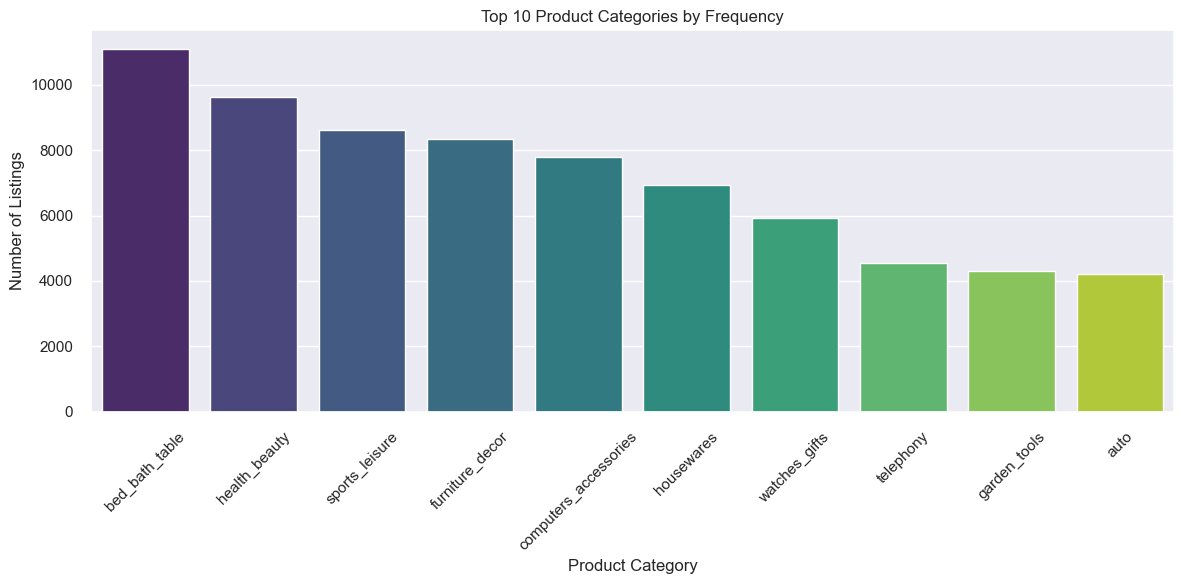

In [180]:
# category frequency bar chart
plt.figure(figsize=(12, 6))
category_counts = listings_clean['category_english'].value_counts().head(10)
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Top 10 Product Categories by Frequency')
plt.xlabel('Product Category')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 2. Median Price per Category

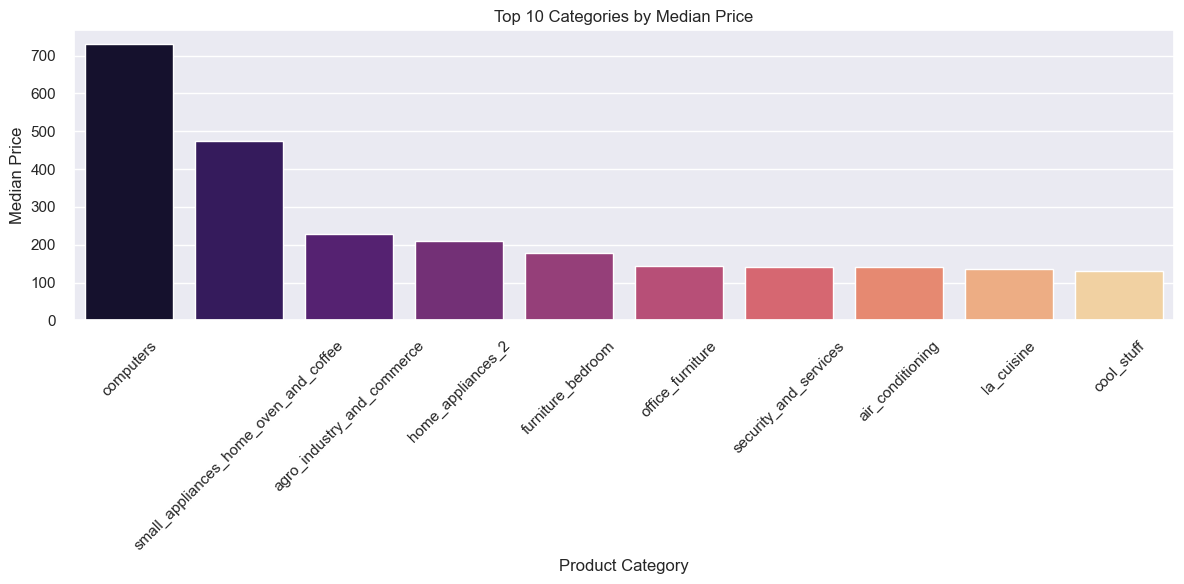

In [181]:
median_prices = listings_clean.groupby('category_english')['price'].median().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=median_prices.index, y=median_prices.values, palette="magma")
plt.title('Top 10 Categories by Median Price')
plt.xlabel('Product Category')
plt.ylabel('Median Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3. Boxplot of price by category

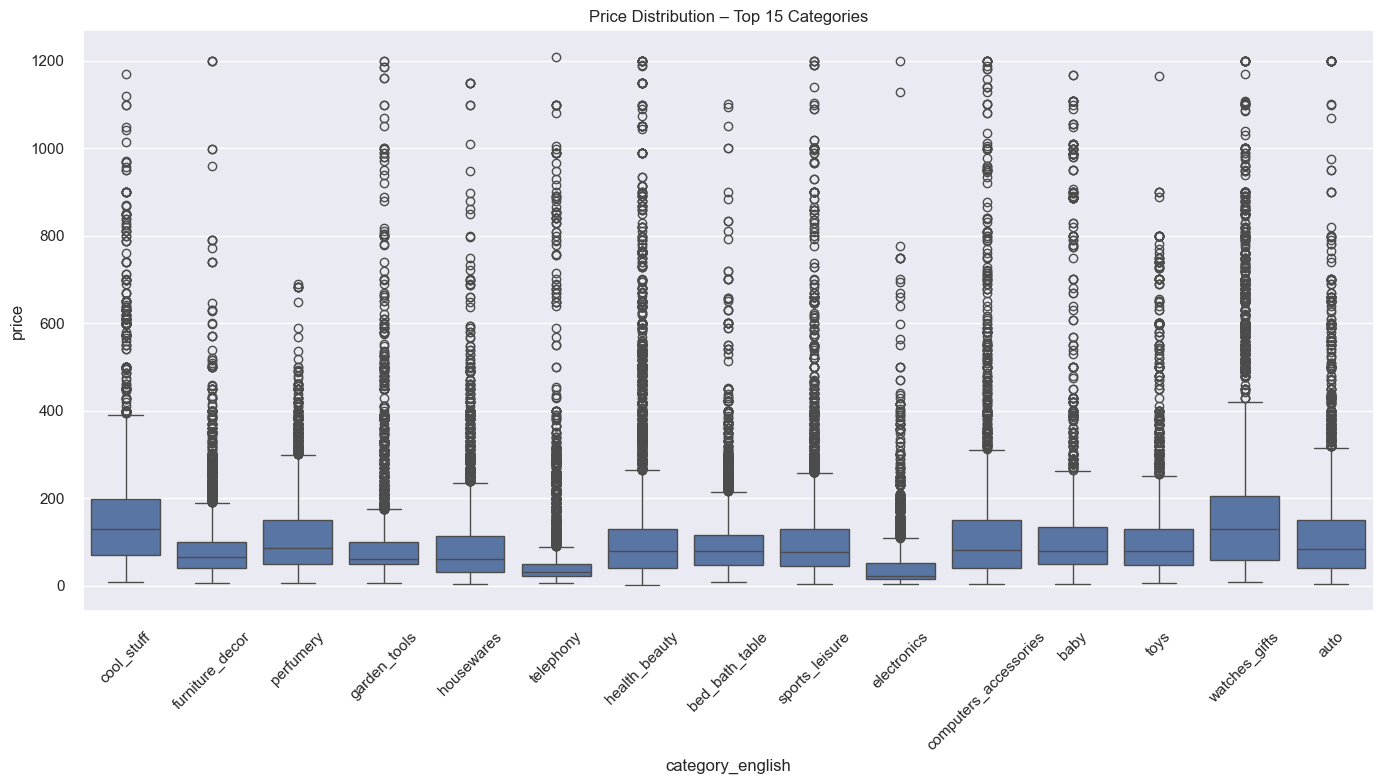

In [182]:
# pick top 15 categories by number of listings
top_cats = (
    listings_clean['category_english']
    .value_counts()
    .head(15)
    .index
)

filtered = listings_clean[listings_clean['category_english'].isin(top_cats)]

plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered, x='category_english', y='price')
plt.title('Price Distribution – Top 15 Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 4. Price Histogram

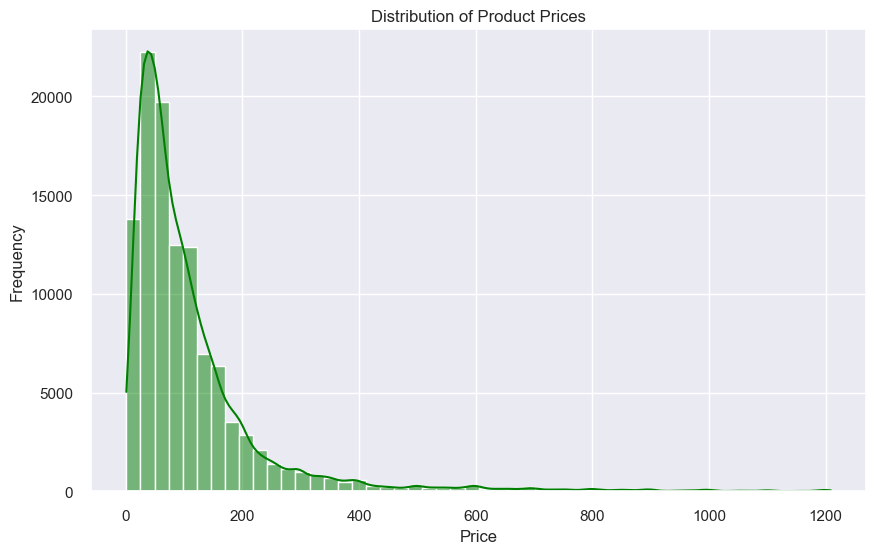

In [183]:
plt.figure(figsize=(10, 6))
sns.histplot(listings_clean['price'], bins=50, kde=True, color='green')
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#### 5. Log price histogram

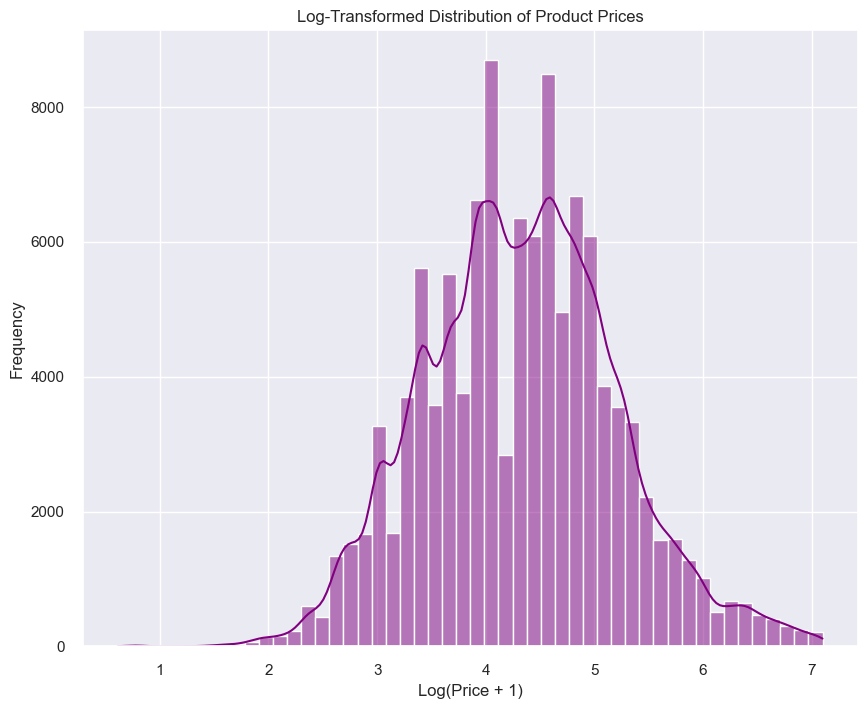

In [184]:
# log price histogram
plt.figure(figsize=(10, 8))
sns.histplot(np.log1p(listings_clean['price']), bins=50, kde=True, color='purple')
plt.title('Log-Transformed Distribution of Product Prices')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.show()


#### 6. Price vs Freight Scatterplot

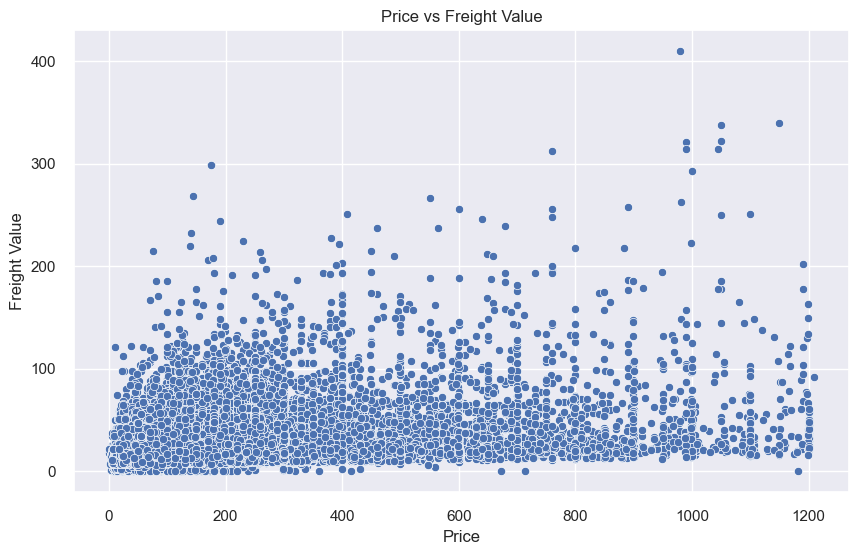

In [185]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=listings_clean, x='price', y='freight_value')
plt.title('Price vs Freight Value')
plt.xlabel('Price')
plt.ylabel('Freight Value')
plt.show()

#### 7. Price vs Volume Scatterplot

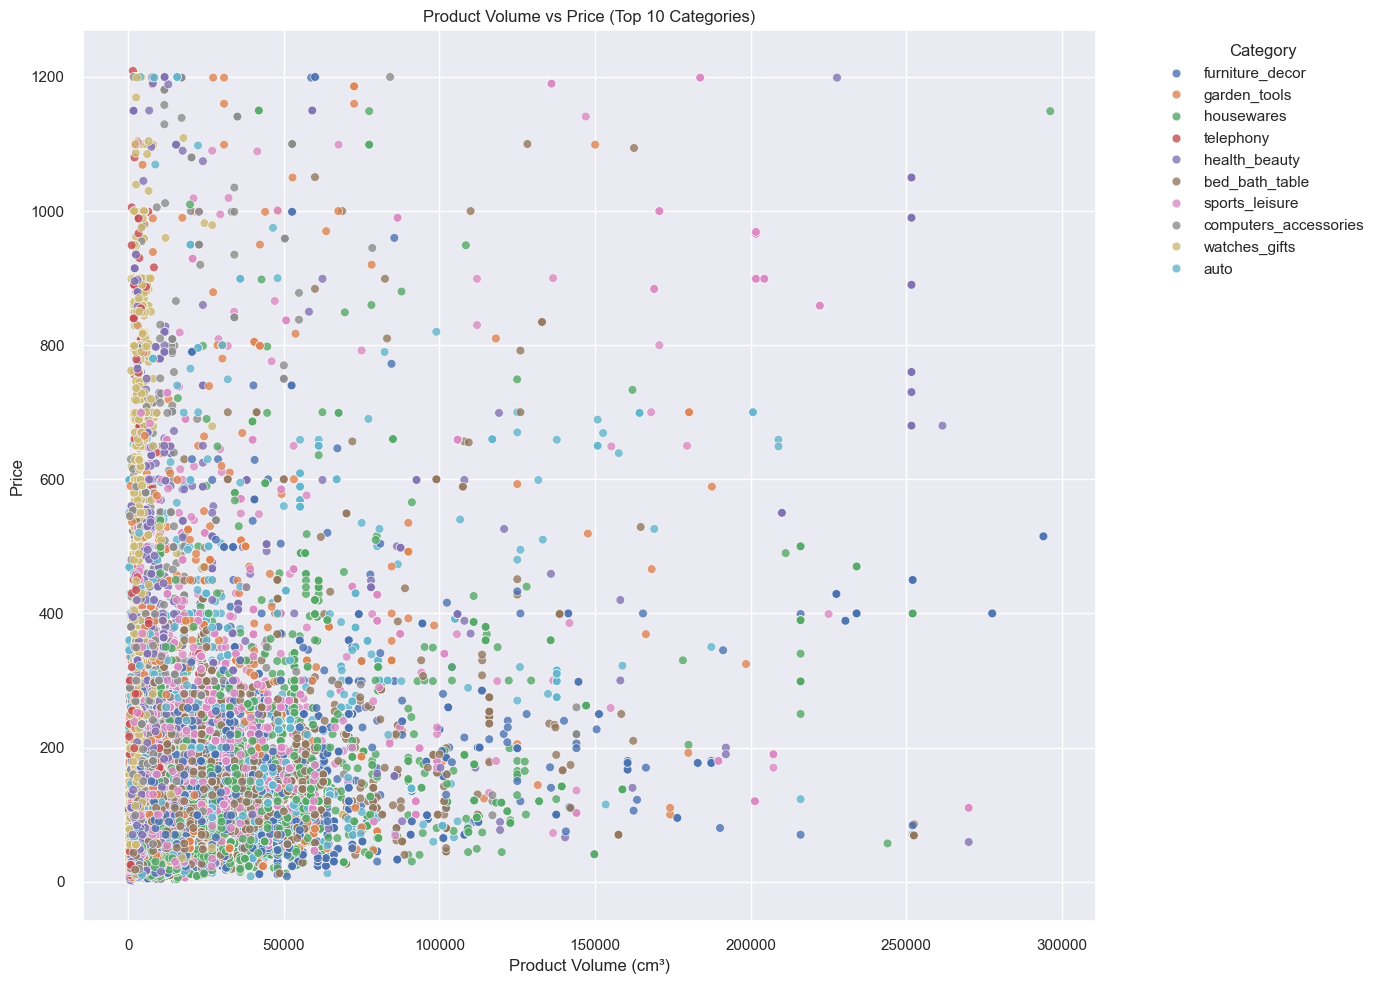

In [186]:
# Get the top 10 categories
top_cats = listings_clean['category_english'].value_counts().nlargest(10).index
filtered = listings_clean[listings_clean['category_english'].isin(top_cats)]

plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=filtered, 
    x='product_volume_cm3', 
    y='price', 
    hue='category_english',
    alpha=0.8,
    s=40
)
plt.title('Product Volume vs Price (Top 10 Categories)')
plt.xlabel('Product Volume (cm³)')
plt.ylabel('Price')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### 8. Correlation Heatmap

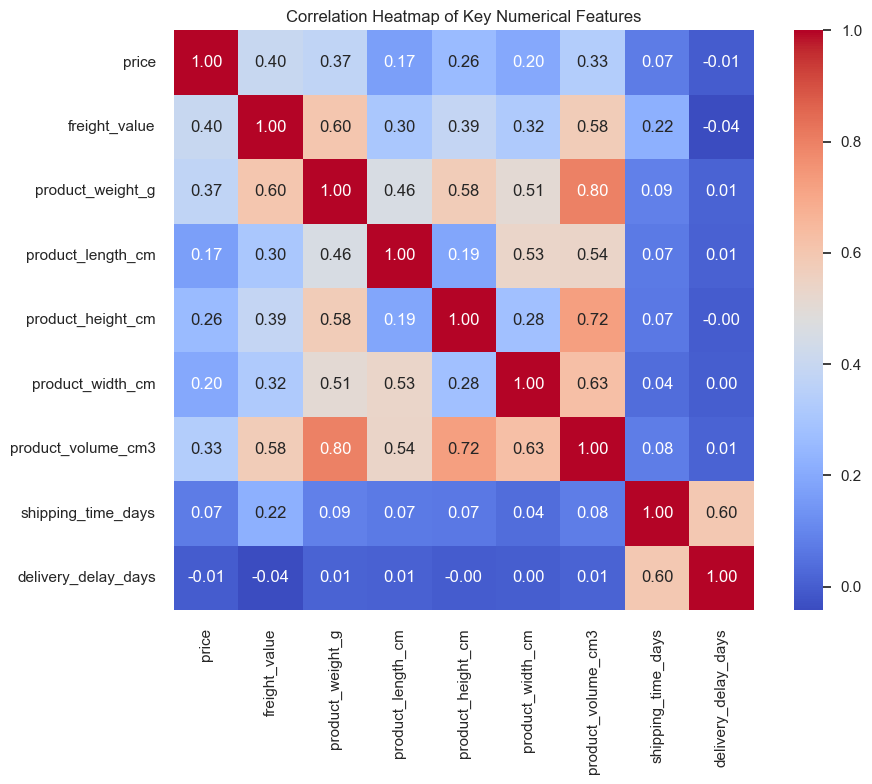

In [187]:
# correlation heatmap
plt.figure(figsize=(10, 8))
corr = listings_clean[[
    'price', 
    'freight_value', 
    'product_weight_g', 
    'product_length_cm', 
    'product_height_cm', 
    'product_width_cm', 
    'product_volume_cm3', 
    'shipping_time_days', 
    'delivery_delay_days'
]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Heatmap of Key Numerical Features')
plt.tight_layout()
plt.show()

#### 9. Price by Seller State

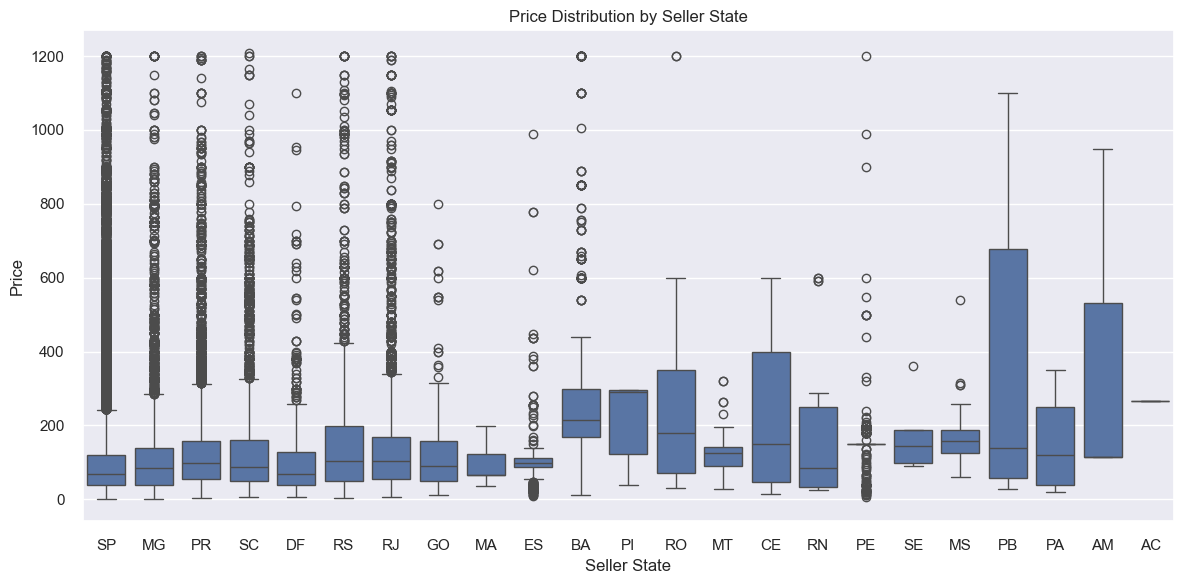

In [188]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=listings_clean, 
    x='seller_state', 
    y='price'
)
plt.title('Price Distribution by Seller State')
plt.xlabel('Seller State')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

#### 10. Shipping Time Distribution

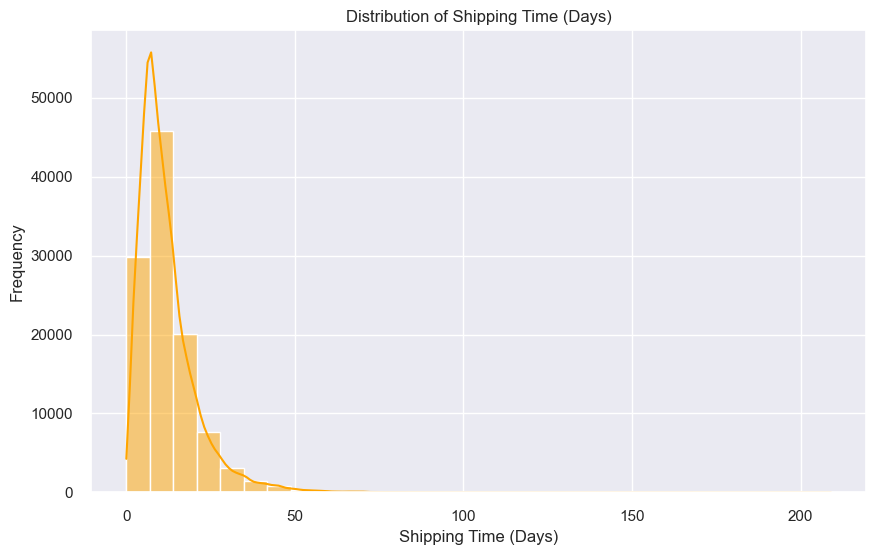

In [189]:
plt.figure(figsize=(10, 6))
sns.histplot(listings_clean['shipping_time_days'], bins=30, kde=True, color='orange')
plt.title('Distribution of Shipping Time (Days)')
plt.xlabel('Shipping Time (Days)')
plt.ylabel('Frequency')
plt.show()  